# 가스 공급량 예측 희망이와 절망이 팀
1) 제공 데이터: 공급량 데이터  
   기간: 2013&#126;2018년  
   구분: A~H

2) 외부 데이터
- 기상 데이터 (출처: https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)  
  기간: 2010~2018년
- 유효일수 데이터 (출처: https://www.data.go.kr/data/15088307/fileData.do)  
  기간: 1985~2018년

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 로드 및 생성

## 공급량 데이터 생성

In [2]:
# 데이터 load
train = pd.read_csv('./한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
train

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
...,...,...,...,...
368083,2018-12-31,20,H,681.033
368084,2018-12-31,21,H,669.961
368085,2018-12-31,22,H,657.941
368086,2018-12-31,23,H,610.953


In [3]:
# 시간 데이터 결합을 위해 0~23으로 변환
train['시간'] = train['시간'] - 1
train

,연월일,시간,구분,공급량
0,2013-01-01,0,A,2497.129
1,2013-01-01,1,A,2363.265
2,2013-01-01,2,A,2258.505
3,2013-01-01,3,A,2243.969
4,2013-01-01,4,A,2344.105
...,...,...,...,...
368083,2018-12-31,19,H,681.033
368084,2018-12-31,20,H,669.961
368085,2018-12-31,21,H,657.941
368086,2018-12-31,22,H,610.953


In [4]:
# 한자리 정수로 표현된 시간 데이터 앞에 0 추가
train['시간'] = np.where(train['시간'] == 0, '00', train['시간'])
train['시간'] = np.where(train['시간'] == '1', '01', train['시간'])
train['시간'] = np.where(train['시간'] == '2', '02', train['시간'])
train['시간'] = np.where(train['시간'] == '3', '03', train['시간'])
train['시간'] = np.where(train['시간'] == '4', '04', train['시간'])
train['시간'] = np.where(train['시간'] == '5', '05', train['시간'])
train['시간'] = np.where(train['시간'] == '6', '06', train['시간'])
train['시간'] = np.where(train['시간'] == '7', '07', train['시간'])
train['시간'] = np.where(train['시간'] == '8', '08', train['시간'])
train['시간'] = np.where(train['시간'] == '9', '09', train['시간'])
train

,연월일,시간,구분,공급량
0,2013-01-01,00,A,2497.129
1,2013-01-01,01,A,2363.265
2,2013-01-01,02,A,2258.505
3,2013-01-01,03,A,2243.969
4,2013-01-01,04,A,2344.105
...,...,...,...,...
368083,2018-12-31,19,H,681.033
368084,2018-12-31,20,H,669.961
368085,2018-12-31,21,H,657.941
368086,2018-12-31,22,H,610.953


In [5]:
# 시점 데이터 생성
train['시점'] = train['연월일'].map(str) + ' ' + train['시간'].map(str)
train

,연월일,시간,구분,공급량,시점
0,2013-01-01,00,A,2497.129,2013-01-01 00
1,2013-01-01,01,A,2363.265,2013-01-01 01
2,2013-01-01,02,A,2258.505,2013-01-01 02
3,2013-01-01,03,A,2243.969,2013-01-01 03
4,2013-01-01,04,A,2344.105,2013-01-01 04
...,...,...,...,...,...
368083,2018-12-31,19,H,681.033,2018-12-31 19
368084,2018-12-31,20,H,669.961,2018-12-31 20
368085,2018-12-31,21,H,657.941,2018-12-31 21
368086,2018-12-31,22,H,610.953,2018-12-31 22


In [6]:
# 시점 데이터 형 변환
train['시점'] = pd.to_datetime(train['시점'], format='%Y-%m-%d %H')
train

,연월일,시간,구분,공급량,시점
0,2013-01-01,00,A,2497.129,2013-01-01 00:00:00
1,2013-01-01,01,A,2363.265,2013-01-01 01:00:00
2,2013-01-01,02,A,2258.505,2013-01-01 02:00:00
3,2013-01-01,03,A,2243.969,2013-01-01 03:00:00
4,2013-01-01,04,A,2344.105,2013-01-01 04:00:00
...,...,...,...,...,...
368083,2018-12-31,19,H,681.033,2018-12-31 19:00:00
368084,2018-12-31,20,H,669.961,2018-12-31 20:00:00
368085,2018-12-31,21,H,657.941,2018-12-31 21:00:00
368086,2018-12-31,22,H,610.953,2018-12-31 22:00:00


In [7]:
# 연월일, 시간 데이터 제거
train.drop(columns=['연월일', '시간'], inplace=True)
train

,구분,공급량,시점
0,A,2497.129,2013-01-01 00:00:00
1,A,2363.265,2013-01-01 01:00:00
2,A,2258.505,2013-01-01 02:00:00
3,A,2243.969,2013-01-01 03:00:00
4,A,2344.105,2013-01-01 04:00:00
...,...,...,...
368083,H,681.033,2018-12-31 19:00:00
368084,H,669.961,2018-12-31 20:00:00
368085,H,657.941,2018-12-31 21:00:00
368086,H,610.953,2018-12-31 22:00:00


In [8]:
# 시점 데이터 index로 변경
train.set_index('시점', inplace=True)
train

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


In [9]:
# test 데이터 load
test = pd.read_csv('./test.csv')
test

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A
...,...
15115,2019-03-31 20 H
15116,2019-03-31 21 H
15117,2019-03-31 22 H
15118,2019-03-31 23 H


In [10]:
# 일자, 시간, 구분 분리
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]
test

,일자|시간|구분,일자,시간,구분
0,2019-01-01 01 A,2019-01-01,1,A
1,2019-01-01 02 A,2019-01-01,2,A
2,2019-01-01 03 A,2019-01-01,3,A
3,2019-01-01 04 A,2019-01-01,4,A
4,2019-01-01 05 A,2019-01-01,5,A
...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H
15116,2019-03-31 21 H,2019-03-31,21,H
15117,2019-03-31 22 H,2019-03-31,22,H
15118,2019-03-31 23 H,2019-03-31,23,H


In [11]:
# 원래 column 제거
test.drop(columns='일자|시간|구분', inplace=True)
test

,일자,시간,구분
0,2019-01-01,1,A
1,2019-01-01,2,A
2,2019-01-01,3,A
3,2019-01-01,4,A
4,2019-01-01,5,A
...,...,...,...
15115,2019-03-31,20,H
15116,2019-03-31,21,H
15117,2019-03-31,22,H
15118,2019-03-31,23,H


In [12]:
# 시간 데이터 결합을 위해 0~23으로 변환
test['시간'] = test['시간'] - 1
test

,일자,시간,구분
0,2019-01-01,0,A
1,2019-01-01,1,A
2,2019-01-01,2,A
3,2019-01-01,3,A
4,2019-01-01,4,A
...,...,...,...
15115,2019-03-31,19,H
15116,2019-03-31,20,H
15117,2019-03-31,21,H
15118,2019-03-31,22,H


In [13]:
# 한자리 정수로 표현된 시간 데이터 앞에 0 추가
test['시간'] = np.where(test['시간'] == 0, '00', test['시간'])
test['시간'] = np.where(test['시간'] == '1', '01', test['시간'])
test['시간'] = np.where(test['시간'] == '2', '02', test['시간'])
test['시간'] = np.where(test['시간'] == '3', '03', test['시간'])
test['시간'] = np.where(test['시간'] == '4', '04', test['시간'])
test['시간'] = np.where(test['시간'] == '5', '05', test['시간'])
test['시간'] = np.where(test['시간'] == '6', '06', test['시간'])
test['시간'] = np.where(test['시간'] == '7', '07', test['시간'])
test['시간'] = np.where(test['시간'] == '8', '08', test['시간'])
test['시간'] = np.where(test['시간'] == '9', '09', test['시간'])
test

,일자,시간,구분
0,2019-01-01,00,A
1,2019-01-01,01,A
2,2019-01-01,02,A
3,2019-01-01,03,A
4,2019-01-01,04,A
...,...,...,...
15115,2019-03-31,19,H
15116,2019-03-31,20,H
15117,2019-03-31,21,H
15118,2019-03-31,22,H


In [14]:
# 시점 데이터 생성
test['시점'] = test['일자'].map(str) + ' ' + test['시간'].map(str)
test

,일자,시간,구분,시점
0,2019-01-01,00,A,2019-01-01 00
1,2019-01-01,01,A,2019-01-01 01
2,2019-01-01,02,A,2019-01-01 02
3,2019-01-01,03,A,2019-01-01 03
4,2019-01-01,04,A,2019-01-01 04
...,...,...,...,...
15115,2019-03-31,19,H,2019-03-31 19
15116,2019-03-31,20,H,2019-03-31 20
15117,2019-03-31,21,H,2019-03-31 21
15118,2019-03-31,22,H,2019-03-31 22


In [15]:
# 시점 데이터 형 변환
test['시점'] = pd.to_datetime(test['시점'], format='%Y-%m-%d %H')
test

,일자,시간,구분,시점
0,2019-01-01,00,A,2019-01-01 00:00:00
1,2019-01-01,01,A,2019-01-01 01:00:00
2,2019-01-01,02,A,2019-01-01 02:00:00
3,2019-01-01,03,A,2019-01-01 03:00:00
4,2019-01-01,04,A,2019-01-01 04:00:00
...,...,...,...,...
15115,2019-03-31,19,H,2019-03-31 19:00:00
15116,2019-03-31,20,H,2019-03-31 20:00:00
15117,2019-03-31,21,H,2019-03-31 21:00:00
15118,2019-03-31,22,H,2019-03-31 22:00:00


In [16]:
# 일자, 시간 데이터 제거
test.drop(columns=['일자', '시간'], inplace=True)
test

,구분,시점
0,A,2019-01-01 00:00:00
1,A,2019-01-01 01:00:00
2,A,2019-01-01 02:00:00
3,A,2019-01-01 03:00:00
4,A,2019-01-01 04:00:00
...,...,...
15115,H,2019-03-31 19:00:00
15116,H,2019-03-31 20:00:00
15117,H,2019-03-31 21:00:00
15118,H,2019-03-31 22:00:00


In [17]:
# 시점 데이터 index로 변경
test.set_index('시점', inplace=True)
test

,구분
시점,
2019-01-01 00:00:00,A
2019-01-01 01:00:00,A
2019-01-01 02:00:00,A
2019-01-01 03:00:00,A
2019-01-01 04:00:00,A
...,...
2019-03-31 19:00:00,H
2019-03-31 20:00:00,H
2019-03-31 21:00:00,H


In [18]:
# train과 test를 합쳐서 data 행성
data = train.append(test)
data

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2019-03-31 19:00:00,H,NaN
2019-03-31 20:00:00,H,NaN
2019-03-31 21:00:00,H,NaN


In [19]:
# 시점, 구분 순으로 오름차순 정렬
data.sort_values(['구분', '시점'], inplace=True)
data

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2019-03-31 19:00:00,H,NaN
2019-03-31 20:00:00,H,NaN
2019-03-31 21:00:00,H,NaN


## 유효일수 데이터 생성

In [20]:
# 유효일수 데이터 불러오기
vday = pd.read_csv('./한국가스공사_도시가스 민수용 일별 유효일수_20210901.csv', encoding='cp949')
vday

,연월일,유효일수
0,1985-01-01,0.94352
1,1985-01-02,1.00528
2,1985-01-03,1.00528
3,1985-01-04,1.00528
4,1985-01-05,0.97210
...,...,...
12503,2019-03-27,NaN
12504,2019-03-28,NaN
12505,2019-03-29,NaN
12506,2019-03-30,NaN


In [21]:
# 연월일 column을 index로 이동
vday['연월일'] = pd.to_datetime(vday['연월일'])
vday = vday.set_index('연월일')
vday

,유효일수
연월일,
1985-01-01,0.94352
1985-01-02,1.00528
1985-01-03,1.00528
1985-01-04,1.00528
1985-01-05,0.97210
...,...
2019-03-27,NaN
2019-03-28,NaN
2019-03-29,NaN


In [22]:
# 요일을 추출하여 저장
vday['요일'] = vday.index.weekday
vday

,유효일수,요일
연월일,,
1985-01-01,0.94352,1
1985-01-02,1.00528,2
1985-01-03,1.00528,3
1985-01-04,1.00528,4
1985-01-05,0.97210,5
...,...,...
2019-03-27,NaN,2
2019-03-28,NaN,3
2019-03-29,NaN,4


In [23]:
# 요일별 최빈 유효일수 값 저장
mode = vday.groupby('요일')['유효일수'].agg(**{'요일별 최빈값':lambda x:x.mode()}).reset_index()
mode

,요일,요일별 최빈값
0,0,1.00518
1,1,1.00528
2,2,1.00528
3,3,1.00528
4,4,1.00528
5,5,0.97210
6,6,0.95411


In [24]:
# 요일별 최빈값을 유효일수_에 저장
vday['유효일수_'] = np.nan
for i in vday['요일'].unique():
    vday['유효일수_'] = np.where(vday['요일'] == i, mode[mode['요일'] == i]['요일별 최빈값'], vday['유효일수_'])
vday

,유효일수,요일,유효일수_
연월일,,,
1985-01-01,0.94352,1,1.00528
1985-01-02,1.00528,2,1.00528
1985-01-03,1.00528,3,1.00528
1985-01-04,1.00528,4,1.00528
1985-01-05,0.97210,5,0.97210
...,...,...,...
2019-03-27,NaN,2,1.00528
2019-03-28,NaN,3,1.00528
2019-03-29,NaN,4,1.00528


In [25]:
# 2019년에 해당하는 데이터 유효일수_로 대체
vday['유효일수'] = np.where(vday['유효일수'].isna(), vday['유효일수_'], vday['유효일수'])
vday.drop(columns=['유효일수_'], inplace=True)
vday

,유효일수,요일
연월일,,
1985-01-01,0.94352,1
1985-01-02,1.00528,2
1985-01-03,1.00528,3
1985-01-04,1.00528,4
1985-01-05,0.97210,5
...,...,...
2019-03-27,1.00528,2
2019-03-28,1.00528,3
2019-03-29,1.00528,4


In [26]:
# 휴일에 해당하는 1월 1일 화요일에 해당하는 유효일수 값 확인
vday[(vday.index.month == 1) & (vday.index.day == 1) & (vday['요일'] == 1)]

,유효일수,요일
연월일,,
1985-01-01,0.94352,1
1991-01-01,0.94352,1
2002-01-01,0.94352,1
2008-01-01,0.94352,1
2013-01-01,0.94352,1
2019-01-01,1.00528,1


In [27]:
# 확인한 값으로 대체
vday.loc['2019-1-1','유효일수'] = 0.94352

In [28]:
# 1월 2일 수요일 값 확인
vday[(vday.index.month == 1) & (vday.index.day == 2) & (vday['요일'] == 2)]

,유효일수,요일
연월일,,
1985-01-02,1.00528,2
1991-01-02,1.00528,2
2002-01-02,1.00528,2
2008-01-02,1.00528,2
2013-01-02,1.00528,2
2019-01-02,1.00528,2


In [29]:
# 19년 설날이 월화수 였으므로 2002년 설날 전후 휴일 데이터 확인
vday['2002-2-10':'2002-2-16']

,유효일수,요일
연월일,,
2002-02-10,0.94304,6
2002-02-11,0.92928,0
2002-02-12,0.87907,1
2002-02-13,0.95152,2
2002-02-14,1.03643,3
2002-02-15,1.05545,4
2002-02-16,0.95975,5


In [30]:
# 해당 값으로 설날 데이터 대체
vday.loc['2019-2-3','유효일수'] = 0.94304
vday.loc['2019-2-4','유효일수'] = 0.92928
vday.loc['2019-2-5','유효일수'] = 0.87907
vday.loc['2019-2-6','유효일수'] = 0.95152
vday.loc['2019-2-7','유효일수'] = 1.03643
vday.loc['2019-2-8','유효일수'] = 1.05545
vday.loc['2019-2-9','유효일수'] = 0.95975

In [31]:
# 3월 1일 금요일 값 확인
vday[(vday.index.month == 3) & (vday.index.day == 1) & (vday['요일'] == 4)]

,유효일수,요일
연월일,,
1985-03-01,0.93477,4
1991-03-01,0.93477,4
1996-03-01,0.93477,4
2002-03-01,0.93477,4
2013-03-01,0.93477,4
2019-03-01,1.00528,4


In [32]:
# 확인한 값으로 대체
vday.loc['2019-3-1','유효일수'] = 0.93477

In [33]:
# 3월 2일 토요일 값 확인
vday[(vday.index.month == 3) & (vday.index.day == 2) & (vday['요일'] == 5)]

,유효일수,요일
연월일,,
1985-03-02,0.95975,5
1991-03-02,0.95975,5
1996-03-02,0.95975,5
2002-03-02,0.95975,5
2013-03-02,0.95975,5
2019-03-02,0.97210,5


In [34]:
# 확인한 값으로 대체
vday.loc['2019-3-2','유효일수'] = 0.95975

In [35]:
# 생성된 vday를 data에 결합
data['vday'] = vday['유효일수']
data['vday'] = data['vday'].fillna(method='ffill')
data

,구분,공급량,vday
시점,,,
2013-01-01 00:00:00,A,2497.129,0.94352
2013-01-01 01:00:00,A,2363.265,0.94352
2013-01-01 02:00:00,A,2258.505,0.94352
2013-01-01 03:00:00,A,2243.969,0.94352
2013-01-01 04:00:00,A,2344.105,0.94352
...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411
2019-03-31 20:00:00,H,NaN,0.95411
2019-03-31 21:00:00,H,NaN,0.95411


## 기상 데이터 생성

In [36]:
# 기상 데이터 불러오기
weather = pd.read_csv('./기상.csv', encoding='cp949')
weather

,지점,지점명,일시,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,108,서울,2010-01-01 0:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
1,108,서울,2010-01-01 1:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2,108,서울,2010-01-01 2:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
3,108,서울,2010-01-01 3:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
4,108,서울,2010-01-01 4:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...
81041,108,서울,2019-03-31 19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81042,108,서울,2019-03-31 20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81043,108,서울,2019-03-31 21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81044,108,서울,2019-03-31 22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# 일시 column을 dt형으로 변환 후 index로 이동
weather['일시'] = pd.to_datetime(weather['일시'], format='%Y-%m-%d %H')
weather.set_index('일시', inplace=True)
weather

,지점,지점명,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,,,
2010-01-01 00:00:00,108,서울,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,108,서울,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,108,서울,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,108,서울,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,108,서울,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,108,서울,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,108,서울,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,108,서울,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# 필요한 columns만 추출
weather = weather[['기온(°C)', '풍속(m/s)', '증기압(hPa)', '이슬점온도(°C)', '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
                   '30cm 지중온도(°C)']]
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# 없는 날짜에 대한 데이터 NaN으로 생성
weather.loc['2011-10-12 18:00:00'] = np.nan
weather.loc['2012-11-29 02:00:00'] = np.nan
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# 생성된 날짜 datetime형으로 변형
weather.index = pd.to_datetime(weather.index, format='%Y-%m-%d %H')
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# index로 정렬
weather = weather.sort_index()
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# 결측을 interpolation으로 대체
for i in weather.columns:
    weather[:'2018'][i] = weather[:'2018'][i].interpolate()
weather

,기온(°C),풍속(m/s),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,3.1,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6
2010-01-01 01:00:00,-11.0,1.2,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6
2010-01-01 02:00:00,-11.1,1.7,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6
2010-01-01 03:00:00,-12.1,1.6,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6
2010-01-01 04:00:00,-12.3,1.4,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# 체감온도 계산
weather['체감온도'] = 13.12 + 0.6215*weather['기온(°C)'] - 11.37*weather['풍속(m/s)']**0.16 + 0.3965*weather['기온(°C)']*weather['풍속(m/s)']**0.16
weather.drop(columns=['풍속(m/s)'], inplace=True)
weather

,기온(°C),증기압(hPa),이슬점온도(°C),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),체감온도
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6,-13.118169
2010-01-01 01:00:00,-11.0,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6,-9.913670
2010-01-01 02:00:00,-11.1,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6,-10.947262
2010-01-01 03:00:00,-12.1,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6,-11.830500
2010-01-01 04:00:00,-12.3,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6,-11.670036
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# 칼럼 명 간단하게 변경
weather.columns = ['기온', '증기압', '이슬점', '지면', '지중_5', '지중_10', '지중_20', '지중_30', '체감']
weather

,기온,증기압,이슬점,지면,지중_5,지중_10,지중_20,지중_30,체감
일시,,,,,,,,,
2010-01-01 00:00:00,-11.5,1.2,-20.3,-6.4,-4.6,-2.0,-0.5,0.6,-13.118169
2010-01-01 01:00:00,-11.0,1.2,-20.6,-6.5,-4.7,-2.1,-0.6,0.6,-9.913670
2010-01-01 02:00:00,-11.1,1.2,-20.4,-6.5,-4.8,-2.1,-0.6,0.6,-10.947262
2010-01-01 03:00:00,-12.1,1.3,-19.5,-6.7,-4.9,-2.2,-0.7,0.6,-11.830500
2010-01-01 04:00:00,-12.3,1.3,-19.9,-6.8,-5.0,-2.3,-0.7,0.6,-11.670036
...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# seasonal 만들어 주는 함수
def create_seasonal(data, y):
    
    # 1년 주기와 하루 주기를 가지는 데이터 생성
    result = seasonal_decompose(data[data.index.year < 2019][y], period=24*365+6) # 24*365+6을 주기로 seasonal_decompose 실행
    result = seasonal_decompose(result.seasonal, period=24) # 생성된 seasonal데이터를 다시 주기 24로 decompose 실행
    data['year'] = result.trend # 생성된 trend를 year에 할당
    
    # 결측치를 주기와 같은 값으로 대체
    data['year_'] = data['year'].shift(-24*365-6) # year의 위쪽 결측을 한번 주기를 shift하여 채움
    data['year__'] = data['year'].shift(24*365+6) # year의 아래쪽 결측을 한번 주기를 shift하여 채움
    data['year'] = np.where(data['year'].isna(), data['year_'], data['year']) # 결측을 채워진 값들로 대체
    data['year'] = np.where(data['year'].isna(), data['year__'], data['year'])
    data.drop(columns=['year_', 'year__'], inplace=True) # 임시 생성한 칼럼 삭제
    
    return data

In [46]:
# 각각의 날씨 변수에 대한 주기들을 data에 결합
for x in weather.columns:
    X = weather[[x]]
    X = create_seasonal(X, x)
    data[str(x)+'_year'] = X['year']
data

,구분,공급량,vday,기온_year,증기압_year,이슬점_year,지면_year,지중_5_year,지중_10_year,지중_20_year,지중_30_year,체감_year
시점,,,,,,,,,,,,
2013-01-01 00:00:00,A,2497.129,0.94352,-15.396796,-8.155138,-14.733236,-16.153496,-15.257624,-14.766306,-13.954800,-13.128765,-16.562741
2013-01-01 01:00:00,A,2363.265,0.94352,-15.366578,-8.124135,-14.582316,-16.199317,-15.268537,-14.778518,-13.961280,-13.130819,-16.498226
2013-01-01 02:00:00,A,2258.505,0.94352,-15.327770,-8.095218,-14.441424,-16.234206,-15.276850,-14.789429,-13.968282,-13.132874,-16.437052
2013-01-01 03:00:00,A,2243.969,0.94352,-15.286363,-8.067606,-14.311211,-16.271968,-15.283603,-14.799041,-13.975806,-13.135189,-16.387217
2013-01-01 04:00:00,A,2344.105,0.94352,-15.239754,-8.037131,-14.173447,-16.300363,-15.289059,-14.807873,-13.983591,-13.137505,-16.313137
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-4.148184,-3.428038,-2.562504,-2.947256,-3.320757,-3.763727,-4.286250,-2.409067
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-4.208904,-3.584605,-2.587071,-2.949682,-3.323177,-3.763793,-4.288121,-2.425852
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,-4.277955,-3.754709,-2.585590,-2.953407,-3.326377,-3.763598,-4.286867,-2.440874


## 1시간, 24시간 전 데이터 생성

In [47]:
# 1시간, 24시간 전 데이터 생성
for i in (1, 24):
    data['공급량-'+str(i)] = data.groupby(['구분'])['공급량'].shift(i)
data = data[data.index >= '2013-1-2']
data

,구분,공급량,vday,기온_year,증기압_year,이슬점_year,지면_year,지중_5_year,지중_10_year,지중_20_year,지중_30_year,체감_year,공급량-1,공급량-24
시점,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-7.581848,-13.194493,-15.346730,-14.570712,-14.409513,-13.842732,-13.097011,-14.875508,2494.457,2497.129
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-7.594354,-13.321319,-15.290788,-14.527519,-14.382711,-13.828411,-13.090492,-14.903040,2345.481,2363.265
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-7.609204,-13.449969,-15.243437,-14.480419,-14.353044,-13.813832,-13.083713,-14.937196,2185.065,2258.505
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,-7.625878,-13.578620,-15.204152,-14.434100,-14.320514,-13.797951,-13.075633,-14.967990,2122.561,2243.969
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,-7.642813,-13.705448,-15.168768,-14.390642,-14.286421,-13.781289,-13.067293,-15.023501,2238.889,2344.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-4.148184,-3.428038,-2.562504,-2.947256,-3.320757,-3.763727,-4.286250,-2.409067,NaN,NaN
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-4.208904,-3.584605,-2.587071,-2.949682,-3.323177,-3.763793,-4.288121,-2.425852,NaN,NaN
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,-4.277955,-3.754709,-2.585590,-2.953407,-3.326377,-3.763598,-4.286867,-2.440874,NaN,NaN


# 이상치 제거

In [48]:
# 이상치 제거를 위해 구분별로 분리
A = data[data['구분'] == 'A']
B = data[data['구분'] == 'B']
C = data[data['구분'] == 'C']
D = data[data['구분'] == 'D']
E = data[data['구분'] == 'E']
G = data[data['구분'] == 'G']
H = data[data['구분'] == 'H']

## A 공급사 이상치 제거

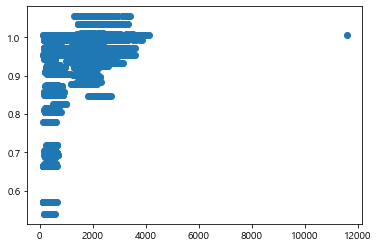

In [49]:
plt.scatter(A['공급량'], A['vday']);

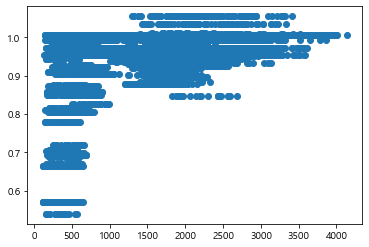

In [50]:
A = A.drop(A[A['공급량'] >= 10000].index)
plt.scatter(A['공급량'], A['vday']);

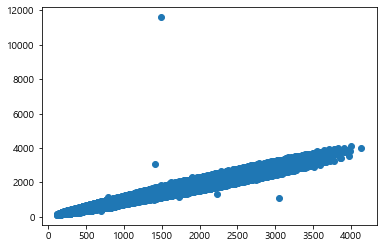

In [51]:
plt.scatter(A['공급량'], A['공급량-1']);

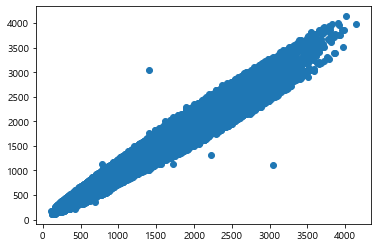

In [52]:
A = A.drop(A[A['공급량-1'] >= 10000].index)
plt.scatter(A['공급량'], A['공급량-1']);

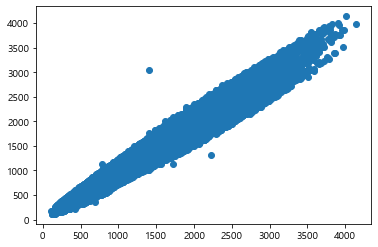

In [53]:
A = A.drop(A[A['공급량'] >= 3000].index & A[A['공급량-1'] <= 1500].index)
plt.scatter(A['공급량'], A['공급량-1']);

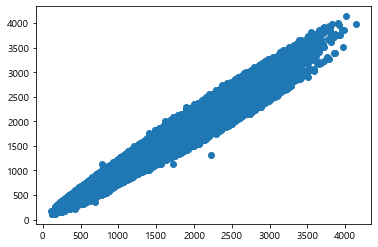

In [54]:
A = A.drop(A[A['공급량'] <= 1500].index & A[A['공급량-1'] >= 3000].index)
plt.scatter(A['공급량'], A['공급량-1']);

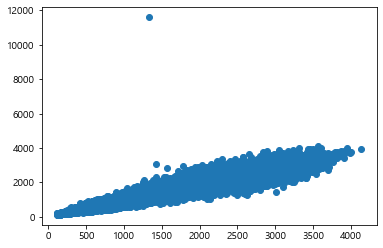

In [55]:
plt.scatter(A['공급량'], A['공급량-24']);

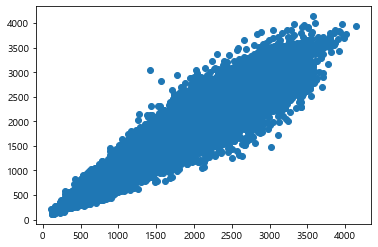

In [56]:
A = A.drop(A[A['공급량-24'] >= 10000].index)
plt.scatter(A['공급량'], A['공급량-24']);

## B 공급사 이상치 제거

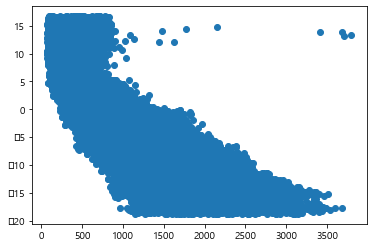

In [57]:
plt.scatter(B['공급량'], B['기온_year']);

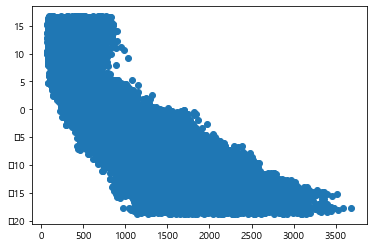

In [58]:
B = B.drop(B[B['공급량'] >= 1000].index & B[B['기온_year'] >= 10].index)
plt.scatter(B['공급량'], B['기온_year']);

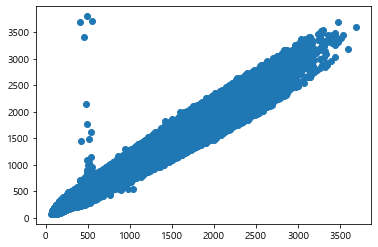

In [59]:
plt.scatter(B['공급량'], B['공급량-1']);

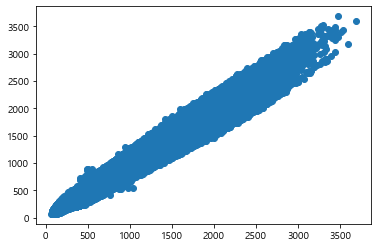

In [60]:
B = B.drop(B[B['공급량'] <= 600].index & B[B['공급량-1'] >= 900].index)
plt.scatter(B['공급량'], B['공급량-1']);

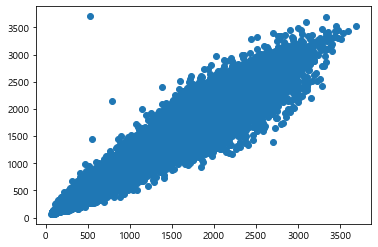

In [61]:
plt.scatter(B['공급량'], B['공급량-24']);

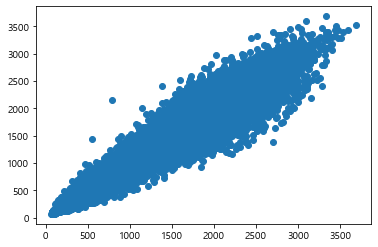

In [62]:
B = B.drop(B[B['공급량'] <= 1000].index & B[B['공급량-24'] >= 3500].index)
plt.scatter(B['공급량'], B['공급량-24']);

## C 공급사 이상치 제거

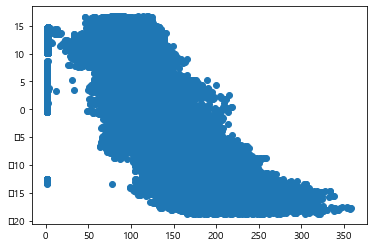

In [63]:
plt.scatter(C['공급량'], C['기온_year']);

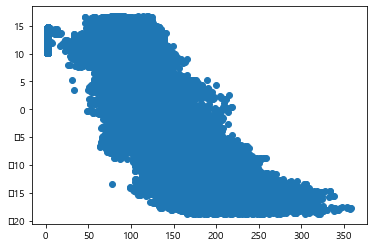

In [64]:
C = C.drop(C[C['공급량'] <= 15].index & C[C['기온_year'] <= 10].index)
plt.scatter(C['공급량'], C['기온_year']);

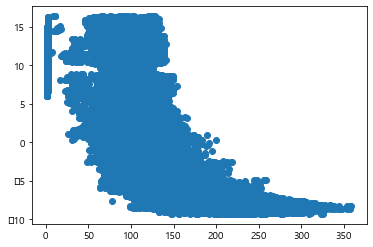

In [65]:
plt.scatter(C['공급량'], C['증기압_year']);

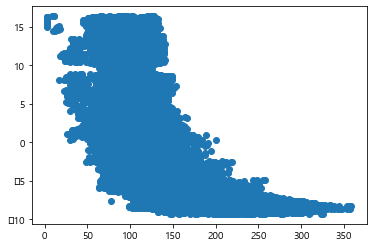

In [66]:
C = C.drop(C[C['공급량'] <= 10].index & C[C['증기압_year'] <= 15].index)
plt.scatter(C['공급량'], C['증기압_year']);

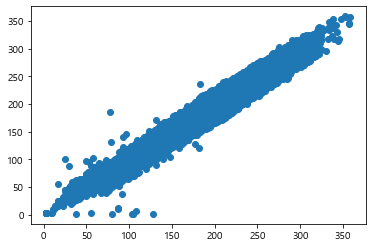

In [67]:
plt.scatter(C['공급량'], C['공급량-1']);

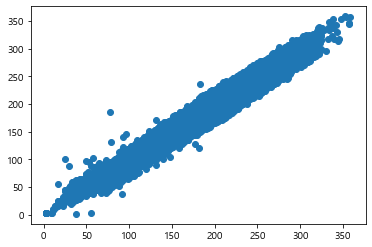

In [68]:
C = C.drop(C[C['공급량'] >= 60].index & C[C['공급량-1'] <= 30].index)
plt.scatter(C['공급량'], C['공급량-1']);

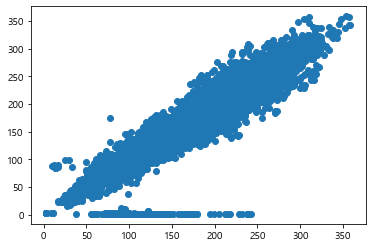

In [69]:
plt.scatter(C['공급량'], C['공급량-24']);

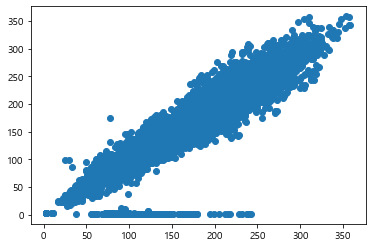

In [70]:
C = C.drop(C[C['공급량'] <= 20].index & C[C['공급량-24'] >= 50].index)
plt.scatter(C['공급량'], C['공급량-24']);

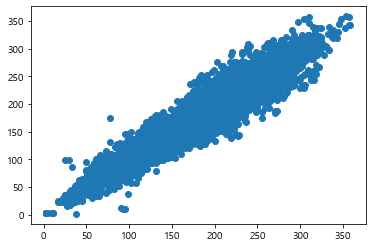

In [71]:
C = C.drop(C[C['공급량'] >= 50].index & C[C['공급량-24'] <= 10].index)
plt.scatter(C['공급량'], C['공급량-24']);

## G 공급사 이상치 제거

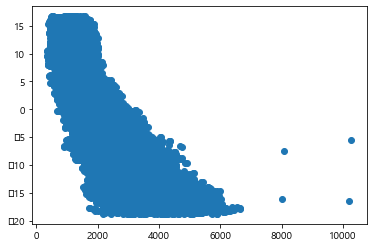

In [72]:
plt.scatter(G['공급량'], G['기온_year']);

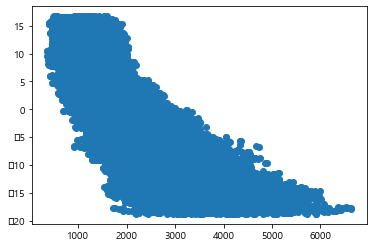

In [73]:
G = G.drop(G[G['공급량'] >= 8000].index)
plt.scatter(G['공급량'], G['기온_year']);

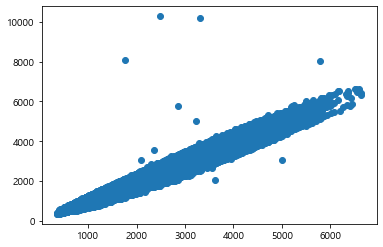

In [74]:
plt.scatter(G['공급량'], G['공급량-1']);

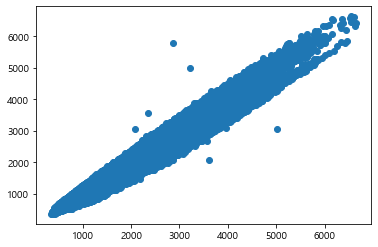

In [75]:
G = G.drop(G[G['공급량'] <= 6000].index & G[G['공급량-1'] >= 8000].index)
plt.scatter(G['공급량'], G['공급량-1']);

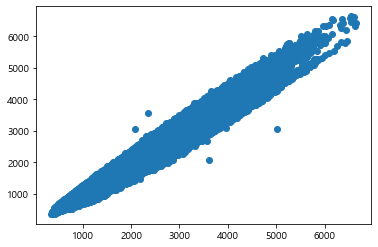

In [76]:
G = G.drop(G[G['공급량'] <= 3500].index & G[G['공급량-1'] >= 4500].index)
plt.scatter(G['공급량'], G['공급량-1']);

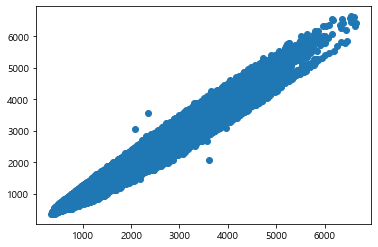

In [77]:
G = G.drop(G[G['공급량'] >= 4500].index & G[G['공급량-1'] <= 3100].index)
plt.scatter(G['공급량'], G['공급량-1']);

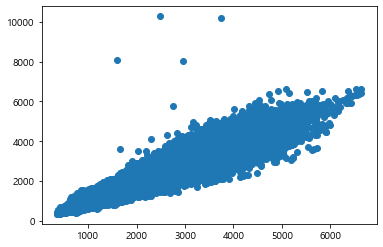

In [78]:
plt.scatter(G['공급량'], G['공급량-24']);

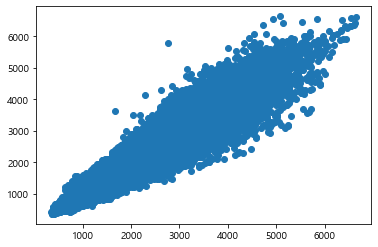

In [79]:
G = G.drop(G[G['공급량'] <= 4000].index & G[G['공급량-24'] >= 8000].index)
plt.scatter(G['공급량'], G['공급량-24']);

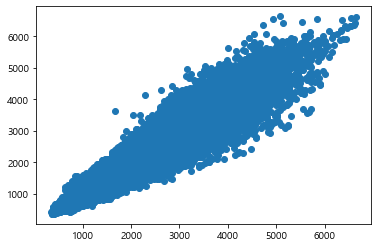

In [80]:
G = G.drop(G[G['공급량'] <= 3000].index & G[G['공급량-24'] >= 5500].index)
plt.scatter(G['공급량'], G['공급량-24']);

## H 공급사 이상치 제거

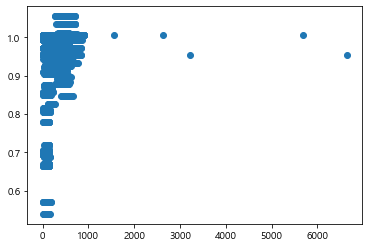

In [81]:
plt.scatter(H['공급량'], H['vday']);

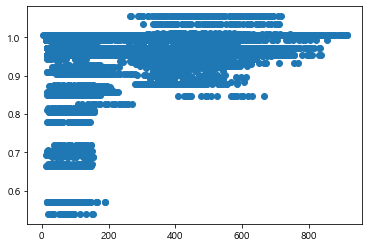

In [82]:
H = H.drop(H[H['공급량'] >= 1500].index)
plt.scatter(H['공급량'], H['vday']);

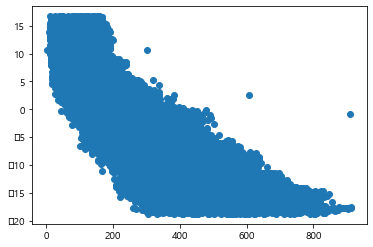

In [83]:
plt.scatter(H['공급량'], H['기온_year']);

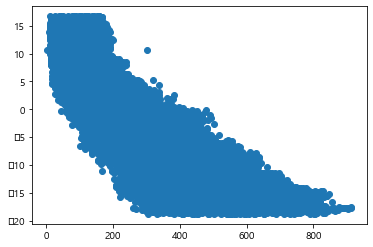

In [84]:
H = H.drop(H[H['공급량'] >= 600].index & H[H['기온_year'] >= -1].index)
plt.scatter(H['공급량'], H['기온_year']);

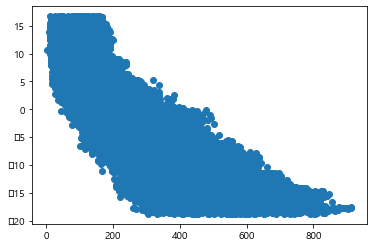

In [85]:
H = H.drop(H[H['공급량'] >= 300].index & H[H['기온_year'] >= 10].index)
plt.scatter(H['공급량'], H['기온_year']);

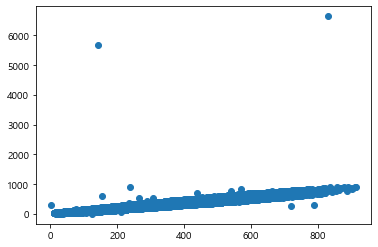

In [86]:
plt.scatter(H['공급량'], H['공급량-1']);

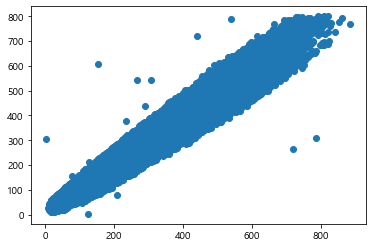

In [87]:
H = H.drop(H[H['공급량-1'] >= 800].index)
plt.scatter(H['공급량'], H['공급량-1']);

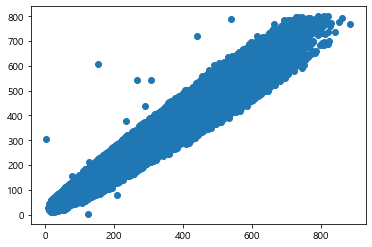

In [88]:
H = H.drop(H[H['공급량'] >= 600].index & H[H['공급량-1'] <= 400].index)
plt.scatter(H['공급량'], H['공급량-1']);

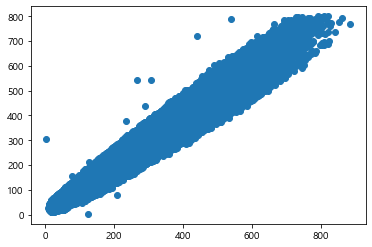

In [89]:
H = H.drop(H[H['공급량'] <= 250].index & H[H['공급량-1'] >= 400].index)
plt.scatter(H['공급량'], H['공급량-1']);

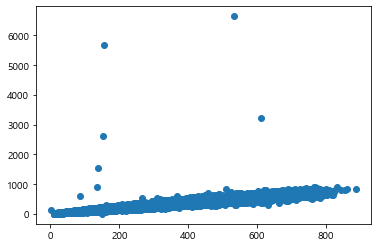

In [90]:
plt.scatter(H['공급량'], H['공급량-24']);

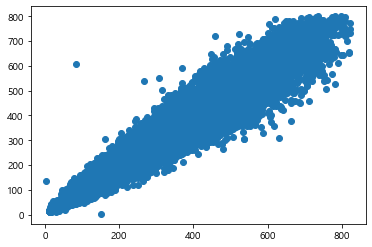

In [91]:
H = H.drop(H[H['공급량-24'] >= 800].index)
plt.scatter(H['공급량'], H['공급량-24']);

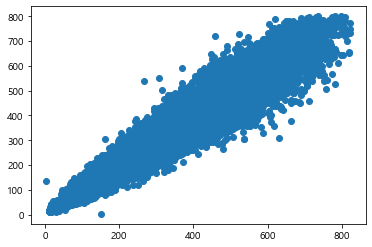

In [92]:
H = H.drop(H[H['공급량-24'] >= 500].index & H[H['공급량'] <= 100].index)
plt.scatter(H['공급량'], H['공급량-24']);

## 이상치 제거된 데이터 결합

In [93]:
# 이상치 제거된 데이터 결합
data = A.append(B).append(C).append(D).append(E).append(G).append(H)
data

,구분,공급량,vday,기온_year,증기압_year,이슬점_year,지면_year,지중_5_year,지중_10_year,지중_20_year,지중_30_year,체감_year,공급량-1,공급량-24
시점,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-7.581848,-13.194493,-15.346730,-14.570712,-14.409513,-13.842732,-13.097011,-14.875508,2494.457,2497.129
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-7.594354,-13.321319,-15.290788,-14.527519,-14.382711,-13.828411,-13.090492,-14.903040,2345.481,2363.265
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-7.609204,-13.449969,-15.243437,-14.480419,-14.353044,-13.813832,-13.083713,-14.937196,2185.065,2258.505
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,-7.625878,-13.578620,-15.204152,-14.434100,-14.320514,-13.797951,-13.075633,-14.967990,2122.561,2243.969
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,-7.642813,-13.705448,-15.168768,-14.390642,-14.286421,-13.781289,-13.067293,-15.023501,2238.889,2344.105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-4.148184,-3.428038,-2.562504,-2.947256,-3.320757,-3.763727,-4.286250,-2.409067,NaN,NaN
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-4.208904,-3.584605,-2.587071,-2.949682,-3.323177,-3.763793,-4.288121,-2.425852,NaN,NaN
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,-4.277955,-3.754709,-2.585590,-2.953407,-3.326377,-3.763598,-4.286867,-2.440874,NaN,NaN


# 월별 평균 데이터 생성

In [94]:
# month를 추출하여 저장
data['month'] = data.index.month
data

,구분,공급량,vday,기온_year,증기압_year,이슬점_year,지면_year,지중_5_year,지중_10_year,지중_20_year,지중_30_year,체감_year,공급량-1,공급량-24,month
시점,,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-7.581848,-13.194493,-15.346730,-14.570712,-14.409513,-13.842732,-13.097011,-14.875508,2494.457,2497.129,1
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-7.594354,-13.321319,-15.290788,-14.527519,-14.382711,-13.828411,-13.090492,-14.903040,2345.481,2363.265,1
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-7.609204,-13.449969,-15.243437,-14.480419,-14.353044,-13.813832,-13.083713,-14.937196,2185.065,2258.505,1
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,-7.625878,-13.578620,-15.204152,-14.434100,-14.320514,-13.797951,-13.075633,-14.967990,2122.561,2243.969,1
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,-7.642813,-13.705448,-15.168768,-14.390642,-14.286421,-13.781289,-13.067293,-15.023501,2238.889,2344.105,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-4.148184,-3.428038,-2.562504,-2.947256,-3.320757,-3.763727,-4.286250,-2.409067,NaN,NaN,3
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-4.208904,-3.584605,-2.587071,-2.949682,-3.323177,-3.763793,-4.288121,-2.425852,NaN,NaN,3
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,-4.277955,-3.754709,-2.585590,-2.953407,-3.326377,-3.763598,-4.286867,-2.440874,NaN,NaN,3


In [95]:
# month변수에 구분 및 각 월의 평균 공급량을 계산하여 대체
for x in data['구분'].unique():
    for h in data['month'].unique():
        data['month'] = np.where((data['구분'] == x) & (data['month'] == h),
                                 data[(data['구분'] == x) & (data['month'] == h)]['공급량'].mean(),
                                 data['month'])
data

,구분,공급량,vday,기온_year,증기압_year,이슬점_year,지면_year,지중_5_year,지중_10_year,지중_20_year,지중_30_year,체감_year,공급량-1,공급량-24,month
시점,,,,,,,,,,,,,,,
2013-01-02 00:00:00,A,2345.481,1.00528,-14.075396,-7.581848,-13.194493,-15.346730,-14.570712,-14.409513,-13.842732,-13.097011,-14.875508,2494.457,2497.129,2297.494201
2013-01-02 01:00:00,A,2185.065,1.00528,-14.089245,-7.594354,-13.321319,-15.290788,-14.527519,-14.382711,-13.828411,-13.090492,-14.903040,2345.481,2363.265,2297.494201
2013-01-02 02:00:00,A,2122.561,1.00528,-14.116895,-7.609204,-13.449969,-15.243437,-14.480419,-14.353044,-13.813832,-13.083713,-14.937196,2185.065,2258.505,2297.494201
2013-01-02 03:00:00,A,2238.889,1.00528,-14.156261,-7.625878,-13.578620,-15.204152,-14.434100,-14.320514,-13.797951,-13.075633,-14.967990,2122.561,2243.969,2297.494201
2013-01-02 04:00:00,A,2475.521,1.00528,-14.207344,-7.642813,-13.705448,-15.168768,-14.390642,-14.286421,-13.781289,-13.067293,-15.023501,2238.889,2344.105,2297.494201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,NaN,0.95411,-2.309277,-4.148184,-3.428038,-2.562504,-2.947256,-3.320757,-3.763727,-4.286250,-2.409067,NaN,NaN,332.351503
2019-03-31 20:00:00,H,NaN,0.95411,-2.308583,-4.208904,-3.584605,-2.587071,-2.949682,-3.323177,-3.763793,-4.288121,-2.425852,NaN,NaN,332.351503
2019-03-31 21:00:00,H,NaN,0.95411,-2.307881,-4.277955,-3.754709,-2.585590,-2.953407,-3.326377,-3.763598,-4.286867,-2.440874,NaN,NaN,332.351503


# 19년 공급량 예측

In [96]:
# 19년 공급량을 예측
PRED = pd.DataFrame() # 예측값을 저장할 데이터프레임 생성

for x in data['구분'].unique(): # 구분별로 따로 모델 생성
    A = data[data['구분'] == x]
    
    test = A[A.index.year == 2019]
    train = A[A.index.year != 2019]
    
    models = {} # 요일별, 시간별 모델을 저장할 딕셔너리 생성
    
    for i in range(168): # 요일별, 시간별 모델을 따로 생성
        X = train[train.index.hour + train.index.weekday*24 == i]

        LR = LinearRegression()
        
        X_train = X['2014':'2015'].drop(columns=['구분', '공급량'])
        y_train = X['2014':'2015']['공급량']
        
        models[i] = LR.fit(X_train, y_train)
        
    for i in range(2160):
        flag = test.iloc[i:i+1,:].index.hour[0] + test.iloc[i:i+1,:].index.weekday[0]*24 # 예측할 순번에 있는 요일, 시간을 flag에 저장

        pred = models[flag].predict(test.iloc[i:i+1,2:]) #해당 row에 있는 데이터로 예측값 생성
        test.loc[i:i+1, '공급량'] = pred[0] # 생성된 예측값을 자리에 맞게 저장
        test.loc[i+1:i+2, '공급량-1'] = pred[0]
        test.loc[i+24:i+25, '공급량-24'] = pred[0]

    PRED = PRED.append(test) # 저장된 데이터프레임을 결합
    
PRED

,구분,공급량,vday,기온_year,증기압_year,이슬점_year,지면_year,지중_5_year,지중_10_year,지중_20_year,지중_30_year,체감_year,공급량-1,공급량-24,month
시점,,,,,,,,,,,,,,,
2019-01-01 00:00:00,A,2303.477303,0.94352,-15.465375,-8.198940,-14.897362,-15.846531,-15.152052,-14.688340,-13.924746,-13.119240,-16.622988,2583.340000,2429.750000,2297.494201
2019-01-01 01:00:00,A,2024.315484,0.94352,-15.491114,-8.218175,-14.976507,-15.860299,-15.158520,-14.694028,-13.927051,-13.119989,-16.680623,2303.477303,2228.795000,2297.494201
2019-01-01 02:00:00,A,1883.471684,0.94352,-15.510346,-8.233506,-15.037944,-15.881359,-15.163166,-14.697373,-13.928575,-13.120478,-16.729792,2024.315484,2120.860000,2297.494201
2019-01-01 03:00:00,A,1970.916535,0.94352,-15.518381,-8.247536,-15.097298,-15.905806,-15.167294,-14.699158,-13.929840,-13.120967,-16.759060,1883.471684,2162.415000,2297.494201
2019-01-01 04:00:00,A,2182.260760,0.94352,-15.516523,-8.256880,-15.142331,-15.920879,-15.170641,-14.700943,-13.930585,-13.122237,-16.761710,1970.916535,2335.875000,2297.494201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-31 19:00:00,H,340.290582,0.95411,-2.309277,-4.148184,-3.428038,-2.562504,-2.947256,-3.320757,-3.763727,-4.286250,-2.409067,309.347680,335.671915,332.351503
2019-03-31 20:00:00,H,342.062839,0.95411,-2.308583,-4.208904,-3.584605,-2.587071,-2.949682,-3.323177,-3.763793,-4.288121,-2.425852,340.290582,327.395629,332.351503
2019-03-31 21:00:00,H,309.256828,0.95411,-2.307881,-4.277955,-3.754709,-2.585590,-2.953407,-3.326377,-3.763598,-4.286867,-2.440874,342.062839,297.953804,332.351503


In [98]:
submission = pd.read_csv('./sample_submission.csv')
submission['공급량'] = PRED.reset_index()['공급량']
submission.to_csv('최종.csv', index=False)